전이학습은 하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용하는 딥러닝 접근법

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
!cp /drive/MyDrive/sign.zip ./

In [9]:
!unzip sign.zip

Archive:  sign.zip
   creating: sign/
  inflating: __MACOSX/._sign         
  inflating: sign/.DS_Store          
  inflating: __MACOSX/sign/._.DS_Store  
   creating: sign/test/
  inflating: __MACOSX/sign/._test    
   creating: sign/train/
  inflating: __MACOSX/sign/._train   
  inflating: sign/test/.DS_Store     
  inflating: __MACOSX/sign/test/._.DS_Store  
   creating: sign/test/10-1/
  inflating: __MACOSX/sign/test/._10-1  
   creating: sign/test/9/
  inflating: __MACOSX/sign/test/._9  
   creating: sign/test/7/
  inflating: __MACOSX/sign/test/._7  
   creating: sign/test/6/
  inflating: __MACOSX/sign/test/._6  
   creating: sign/test/1/
  inflating: __MACOSX/sign/test/._1  
   creating: sign/test/8/
  inflating: __MACOSX/sign/test/._8  
   creating: sign/test/10-2/
  inflating: __MACOSX/sign/test/._10-2  
   creating: sign/test/4/
  inflating: __MACOSX/sign/test/._4  
   creating: sign/test/3/
  inflating: __MACOSX/sign/test/._3  
   creating: sign/test/2/
  inflating: __MACOSX/

In [20]:
!ls -al # test와 train 이 있는지 확인

total 2189676
drwxr-xr-x 1 root root       4096 Jul 28 06:26 .
drwxr-xr-x 1 root root       4096 Jul 28 06:21 ..
drwxr-xr-x 4 root root       4096 Jul 13 13:42 .config
drwxr-xr-x 3 root root       4096 Jul 28 06:26 __MACOSX
drwxr-xr-x 1 root root       4096 Jul 13 13:43 sample_data
drwx------ 4 root root       4096 Jul 27 11:18 sign
-rw------- 1 root root 2242198059 Jul 28 06:22 sign.zip


In [21]:
 #전처리와 이미지확인을 위한 라이브러리 임포트
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds  
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Flatten

import time

In [22]:
# train과 test데이터의 디렉토리 이름설정
import pathlib
train_data_dir = 'sign/train'
test_data_dir = 'sign/test'
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = pathlib.Path(test_data_dir)

In [24]:
batch_size = 32
img_height = 180
img_width = 180

In [25]:
#train 데이터셋 preprocessing (tensorflow의 라이브러리를 활용한)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 773 files belonging to 11 classes.
Using 619 files for training.


In [27]:
# 숫자별 클래스 확인
class_names = train_ds.class_names
print(class_names)

['1', '10-1', '10-2', '2', '3', '4', '5', '6', '7', '8', '9']


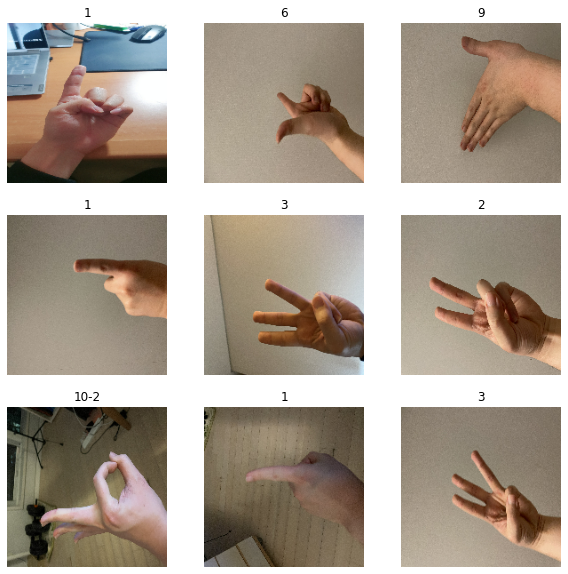

In [28]:
#데이터 몇개정도 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 예측을 위한 함수 선언

In [2]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import vgg16
import numpy as np
import matplotlib.pyplot as plt

In [45]:
def predict_vgg16(model, filename) :

  
  # 모델 사이즈로 이미지 파일을 읽기
  image = load_img(filename, target_size=(224, 224))
  # image = PIL.Image.Image image mode=RGB size=224x224

  
  # 이미지 데이터를 numpy로 변환
  image = img_to_array(image)
  # [
  #   [[211. 184. 163.]
  #   [225. 193. 170.]
  #   ...
  #   [237. 202. 180.]]
  #   ...
  # ]  
  #
  # image.shape = (224, 224, 3)
  
  # 화면에 이미지 보여주기
  plt.imshow(image.astype(int))
  plt.show()

  # vgg16.preprocess_input()을 호출하기 위해 차원을 조정
  # 보통 모델을 여러 이미지를 한번에 호출. 
  # 맨 앞의 1 : 이미지 갯수가 1개라는 것.
  # 두번째 224 : 세로
  # 세번째 224 : 가로
  # 네번째 3 : R, G, B 채널 3개
  image = image.reshape((1, 224, 224, 3))

  # VGG16 모델 호출을 위해 데이터 전처리.
  # -255 ~ 255 사이 값으로 정규화한다.
  # 그리고 RGB를 BGR순으로 바꾼다.
  image = vgg16.preprocess_input(image)
  
  
  # 이미지를 모델에 적용
  yhat = model.predict(image)
  # yhat = [[2.03485320e-06 4.21382174e-06 1.45730738e-07 1.04057870e-06
  #          6.61934010e-08 2.63145339e-04 4.49358195e-05 2.03222541e-08
  #          ... ]] # 1000개 클래스에 대한 결과값.
  #
    
    
  # 모델 적용된 결과를 파싱
  label = vgg16.decode_predictions(yhat)
  # label = [[('n02655020', 'puffer', 0.9612253), ... ]]

  # 가장 확률이 높은 결과를 획득
  label = label[0][0]
  # label = ('n02655020', 'puffer', 0.9612253)

  # 라벨과 라벨을 예측한 확률을 출력
  print('%s (%.2f%%)' % (label[1], label[2]*100))    

   

# 사진 분류

In [ ]:
from tensorflow.keras.applications import vgg16

# VGG16 모델 불러오기
model = vgg16.VGG16()

# 모델의 모양을 보여준다.
model.summary()

# 테스트 할 이미지 파일들
files = [
      'imagenet/mushroom1.jpg',
      'imagenet/mushroom2.jpg',
      'imagenet/mushroom3.jpg',
      'imagenet/dog1.jpg',
      'imagenet/dog2.jpg',
      'imagenet/dog3.jpg',
      'imagenet/cat1.jpg',
      'imagenet/cat2.jpg',
      'imagenet/cat3.jpg',
    ]

# 분류 실행
for file in files :
  predict_vgg16(model, file)  

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# VGG16 모델 불러오기
model = vgg16.VGG16()

# 모델의 모양을 보여준다.
model.summary()

# 테스트 할 이미지 파일들
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "sign/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "sign/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

# 분류 실행
for file in files :
  predict_vgg16(model, file)  

# overfitting, batchnormalization, dropout


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dense (Dense)               (None, 256)               17662208  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

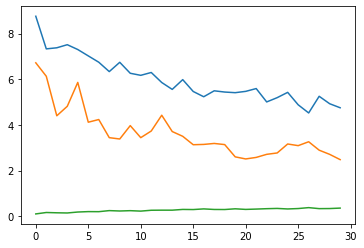

6/6 [==============================] - 42s 7s/step - loss: 2.4769 - acc: 0.3879
loss= 2.476865768432617
acc= 0.38787877559661865


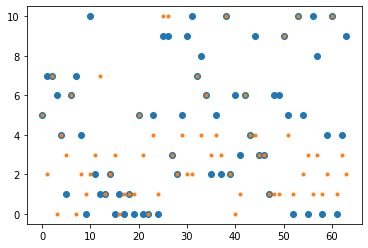

label category index = 5.0
predicted category index = 5
predicted category name = 4


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax')) # 카테고리 갯수가 11개

model.add(GaussianNoise(0.5))   # ADDED



model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "sign/train", # 데이터를 읽어드릴 폴더 위치
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "sign/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)



history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=30
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



train_x, train_y = test_data_generator.next()
y_ = model.predict(train_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(train_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", train_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

model.save("sign2.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_2 (Flatten)         (None, 68992)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               17662208  
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 11)                2827      
                                                                 
Total params: 25,434,628
Trainable params: 17,665,547
Non-trainable params: 7,769,081
__________________________________

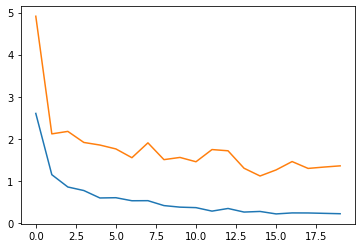

6/6 [==============================] - 42s 7s/step - loss: 1.3609 - acc: 0.6636
loss= 1.3609318733215332
acc= 0.6636363863945007


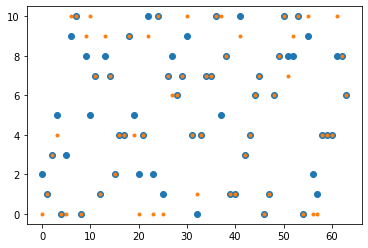

label category index = 2.0
predicted category index = 0
predicted category name = 1


In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(11, activation='softmax')) # 카테고리 갯수가 5개

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "sign/train", # 데이터를 읽어드릴 폴더 위치
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "sign/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=20
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])

In [47]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l1, l2, L1L2

model = Sequential()
model.add(Input(2))
model.add(GaussianNoise(0.1))   # ADDED
model.add(Dense(20, activation='relu', kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu', kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

history = model.fit(train_x, train_y, epochs=1000, batch_size=128, verbose=0, validation_split=0.2)


plt.plot(base_history.history['loss'], label='train_loss')
plt.plot(base_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l1, l2, L1L2

model = Sequential()
model.add(Input(11))
model.add(GaussianNoise(0.1))   # ADDED
model.add(Dense(256, activation='relu', kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(11, activation="softmax"))
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

history = model.fit(train_x, train_y, epochs=300, batch_size=32, verbose=1, validation_split=0.2)


plt.plot(base_history.history['loss'], label='train_loss')
plt.plot(base_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

NameError: ignored

# by DenseNet

In [36]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

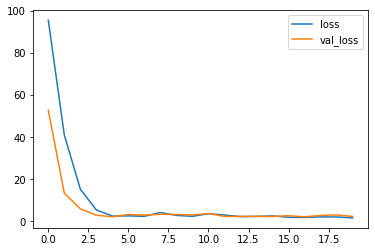

loss =  1.6606385707855225 , val_loss =  2.3486082553863525
5/5 [==============================] - 45s 9s/step - loss: 2.1831 - acc: 0.3788 
loss= 2.1830615997314453
acc= 0.3787878751754761
7 6


In [46]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# from tensorflow.keras.applications import vgg16
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications import resnet50
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import densenet # <------------------
from tensorflow.keras.applications import DenseNet121 # <------------------


# conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(11, activation='softmax')) # <------------------

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
#       preprocessing_function=vgg16.preprocess_input
      preprocessing_function=densenet.preprocess_input    # <--------------------------------------
).flow_from_directory(
      "sign/train",   
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
#       preprocessing_function=vgg16.preprocess_input
      preprocessing_function=densenet.preprocess_input   # <--------------------------------------
).flow_from_directory(
      "sign/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

plot_losses = PlotLosses()     # <--------------------------------------

model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      validation_steps=test_data_generator.samples/128,      
      epochs=20,     # <--------------------------------------
      callbacks=[plot_losses]     # <--------------------------------------
)

loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

y_ = model.predict(
      test_data_generator,
      steps=test_data_generator.samples/64
)

custom_labels = list(test_data_generator.class_indices.keys())
predicted = np.argmax(y_, axis=1)
print(predicted[0], custom_labels[predicted[0]])

 # 모델 저장

In [40]:
model.save("sign.h5")

In [41]:
!ls -alh

total 2.1G
drwxr-xr-x 1 root root 4.0K Jul 28 08:48 .
drwxr-xr-x 1 root root 4.0K Jul 28 06:21 ..
drwxr-xr-x 4 root root 4.0K Jul 13 13:42 .config
drwxr-xr-x 3 root root 4.0K Jul 28 06:26 __MACOSX
drwxr-xr-x 1 root root 4.0K Jul 13 13:43 sample_data
drwx------ 4 root root 4.0K Jul 27 11:18 sign
-rw-r--r-- 1 root root 319K Jul 28 08:48 sign.h5
-rw------- 1 root root 2.1G Jul 28 06:22 sign.zip


553476096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

NameError: ignored

Q2. relu 옆의 dense와 softmax의 dense 차이점

In [39]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l1, l2, L1L2

model = Sequential()
model.add(Input(11))
model.add(GaussianNoise(0.1))   # ADDED
model.add(Dense(256, activation='relu', kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(11, activation="softmax"))
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

history = model.fit(train_x, train_y, epochs=300, batch_size=32, verbose=1, validation_split=0.2)


plt.plot(base_history.history['loss'], label='train_loss')
plt.plot(base_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

NameError: ignored

# 이미지 분류

Found 330 images belonging to 11 classes.
Found 773 images belonging to 11 classes.


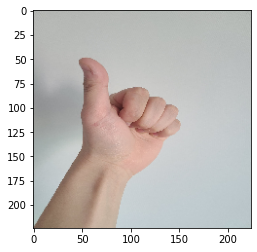

IndexError: ignored

In [43]:
not_preprocessing_test_data_generator = ImageDataGenerator(
).flow_from_directory(
      "sign/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

not_preprocessing_test_data_generator = ImageDataGenerator(
).flow_from_directory(
      "sign/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

batch_test_data, _ = next(not_preprocessing_test_data_generator)
preprocessed_batch_test_data = vgg16.preprocess_input(batch_test_data.copy())

y_ = model.predict(preprocessed_batch_test_data)
predicted = np.argmax(y_, axis=1)


for i in range(len(batch_test_data)):
  plt.imshow(batch_test_data[i]/255.)
  plt.show()
  print(custom_labels[predicted[i]])


# Webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from IPython.display import clear_output
import warnings
import os 
from glob import glob 
import pandas as pd 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

웹캠 실행

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

모델 로딩

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          '끝내려면 여기를 클릭하세요.</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, overay_img):
  data = eval_js('stream_frame("{}", "{}")'.format(label, overay_img))
  return data

# 모델 로딩

In [ ]:
import tensorflow

model = tensorflow.keras.models.load_model("sign.h5")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Classifier:

    def classify(self, image):
        
        predicted = model.predict(np.expand_dims(image, axis=0))
        return np.argmax(predicted, axis=1)[0]

classifier = Classifier()

In [ ]:
# start streaming video from webcam
video_stream()

# label for video
result = 'Capturing...'

# initialze bounding box to empty
overray_bytes = ''
count = 0 
class_name = { 0:"down", 1:"up" }
lst=[]

f=open("th.txt",'w')

if KeyboardInterrupt:
  print(lst)

while True:
    js_reply = video_frame(result, overray_bytes)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    img = cv2.resize(img, (224, 224))

    category = classifier.classify(img)
    # print(f"thumb : {class_name[category]}")

    # create transparent overlay for bounding box
    overray_img = np.zeros([480,640,4], dtype=np.uint8)
    cv2.putText(overray_img, class_name[category], (240,320), cv2.FONT_HERSHEY_SIMPLEX, 10, 255)

    # convert overlay of bbox into bytes
    overray_bytes = bbox_to_bytes(overray_img)
    result = class_name[category]
    f.write(result)
    f.write("\n")
    print(result)

else:
  f.close()


In [ ]:
!tar cvfz thumb.tar.gz thumb

In [ ]:
!cp sign.h5 /gdrive/MyDrive/tmp/
!cp sign.tar.gz /gdrive/MyDrive/tmp/